# Import Libraries

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  2


In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import tensorflow
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from sklearn import preprocessing
import math

# Data Preprocessing

In [4]:
csv_file = "denser_data_collection.csv" #"denser_data_collection_marker.csv" #"data_collection.csv"
columns = ['Serial_no','Timestamp', 'x_actual', 'y_actual', 'direction', 'x_step', 'y_step']
data_df = pd.read_csv(csv_file, header=None, names = columns)

serial_numbers = data_df['Serial_no'].astype(str).apply(lambda x: int(x.split(',')[0]))

image_folder = "output_images_denser" #"output_images_denser_marker" #"cropped_noedges_new" #"output_images_new" #"images_resized_500"
imagess_left = []
imagess_right = []

parsed_custom_info_left = []
parsed_custom_info_right = []


le = preprocessing.LabelEncoder()
data_df['direction'] = le.fit_transform(data_df['direction'])


count_direction_0 = data_df[data_df['direction'] == 0].shape[0]
count_direction_1 = data_df[data_df['direction'] == 1].shape[0]


print("Number of rows with direction 0:", count_direction_0)
print("Number of rows with direction 1:", count_direction_1)



serial_numbers = set(data_df['Serial_no'])
date_time = data_df['Timestamp']
x_coordinate = data_df['x_actual']
y_coordinate = data_df['y_actual']
direction = data_df['direction']
x_step = data_df['x_step']
y_step = data_df['y_step']


image_files = os.listdir(image_folder)


contact = 0
non_contact = 1

for row in data_df.itertuples(index=False, name='data_df'):
    serial_number = row.Serial_no
    date_time = row.Timestamp
    x_coordinate = row.x_actual
    y_coordinate = row.y_actual
    direction = row.direction
    x_step = row.x_step
    y_step = row.y_step


    ############################## contact and right direction data only
    if (110 <= y_step <= 162) and (126 >= x_step >= 2): #Keeping only the trustworthy data for training
    # if (-30 <= y_coordinate <= -21.5) and (-3.5 >= x_coordinate >= -8): 
        if pd.notnull(x_coordinate) and pd.notnull(y_coordinate) and \
            direction == 1 and -12.5 <= x_coordinate <= 4.49:
                matching_files = [filename for filename in image_files if filename.startswith(str(serial_number))]
                if matching_files:
                    image_name = matching_files[0]  # Assuming there is only one matching file
                    image_path = os.path.join(image_folder, image_name)
                    image = cv2.imread(image_path)
                    # if image is not None: 
                    imagess_right.append(image)
                    parsed_custom_info_right.append([x_coordinate, y_coordinate])


    ############################# contact and left direction data only
    if (148 <= y_step <= 204) and (126 >= x_step >= 2): #Keeping only the trustworthy data for training
    # if (-30 <= y_coordinate <= -21.5) and (-7.5 >= x_coordinate >= -12.5):
        if pd.notnull(x_coordinate) and pd.notnull(y_coordinate) and \
            direction == 0 and -18.81 <= x_coordinate <= -3.075:
                matching_files = [filename for filename in image_files if filename.startswith(str(serial_number))]
                if matching_files:
                    image_name = matching_files[0]  # Assuming there is only one matching file
                    image_path = os.path.join(image_folder, image_name)
                    image = cv2.imread(image_path)
                    # if image is not None: 
                    imagess_left.append(image)
                    parsed_custom_info_left.append([x_coordinate, y_coordinate])

Number of rows with direction 0: 7853
Number of rows with direction 1: 7857


In [5]:
print(data_df.shape)

(15710, 7)


In [6]:
print(len(imagess_left))
print(len(parsed_custom_info_left))

685
685


In [6]:
# print(len(imagess))

11357


In [7]:
# print(len(parsed_custom_info))

11357


In [7]:
print(len(imagess_right))
print(len(parsed_custom_info_right))

864
864


In [8]:
print(data_df['direction'].isnull().sum())

0


In [9]:
!nvidia-smi # A command to view the NVIDIA GPU details (especially to view the memory usage while running the code) 

Thu Aug 24 07:46:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  | 00000000:41:00.0 Off |                  Off |
| 30%   42C    P8              29W / 300W |      6MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
data_left = list(zip(imagess_left, parsed_custom_info_left))
data_right = list(zip(imagess_right, parsed_custom_info_right))


In [11]:
from keras.backend import set_session

<b>Note</b>: the next two blocks of code and the block of code towards the end where the session is closed was \
used to clear GPU memory. \
<b>Reference</b>: https://saturncloud.io/blog/how-to-clear-tensorflow-gpu-memory-after-model-execution/
\
<br>
<b>Important</b>: It is no longer necessary to use these three blocks of code. \
<b>A way round this problem</b>: Just refresh the kernel of the notebook once (a few times if necessary) \
to ensure the GPU memory gets cleared. 

In [12]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
config = tf.ConfigProto()
# config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)


In [14]:
print(len(data_left))
print(len(data_right))

685
864


In [15]:
# Shuffle and split the dataset
np.random.shuffle(data_left)
train_ratio_left = 0.8
train_size_left = int(len(data_left) * train_ratio_left)

train_data_left = data_left[:train_size_left]
test_data_left = data_left[train_size_left:]

X_train_left = [item[0] for item in train_data_left]
Y_train_left = [item[1] for item in train_data_left]

X_test_left = [item[0] for item in test_data_left]
Y_test_left = [item[1] for item in test_data_left]

# Shuffle and split the dataset
np.random.shuffle(data_right)
train_ratio_right = 0.8
train_size_right = int(len(data_right) * train_ratio_right)

train_data_right = data_right[:train_size_right]
test_data_right = data_right[train_size_right:]

X_train_right = [item[0] for item in train_data_right]
Y_train_right = [item[1] for item in train_data_right]

X_test_right = [item[0] for item in test_data_right]
Y_test_right = [item[1] for item in test_data_right]

In [16]:
X_test1_left = np.array(X_test_left)
X_train1_left = np.array(X_train_left)

X_test1_right = np.array(X_test_right)
X_train1_right = np.array(X_train_right)

In [17]:
X_test1_left = X_test1_left.astype('float32')
X_train1_left = X_train1_left.astype('float32')

X_test1_right = X_test1_right.astype('float32')
X_train1_right = X_train1_right.astype('float32')

In [18]:
X_test1_left /= 255
X_test1_right /= 255

In [19]:
X_train1_left /= 255
X_train1_right /= 255

In [20]:
Y_train_left = np.array(Y_train_left)
Y_test_left = np.array(Y_test_left)

Y_train_right = np.array(Y_train_right)
Y_test_right = np.array(Y_test_right)

In [21]:
print("Shape X_train_left: ", np.shape(X_train1_left))
print("Shape Y_train_left: ", np.shape(Y_train_left))

print("Shape X_test_left: ", np.shape(X_test1_left))
print("Shape Y_test_left: ", np.shape(Y_test_left))

print("Shape X_train_right: ", np.shape(X_train1_right))
print("Shape Y_train_right: ", np.shape(Y_train_right))

print("Shape X_test_right: ", np.shape(X_test1_right))
print("Shape Y_test_right: ", np.shape(Y_test_right))

Shape X_train_left:  (548, 1080, 1920, 3)
Shape Y_train_left:  (548, 2)
Shape X_test_left:  (137, 1080, 1920, 3)
Shape Y_test_left:  (137, 2)
Shape X_train_right:  (691, 1080, 1920, 3)
Shape Y_train_right:  (691, 2)
Shape X_test_right:  (173, 1080, 1920, 3)
Shape Y_test_right:  (173, 2)


In [22]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [23]:
from keras.layers import MaxPooling2D

# ############################

In [26]:
# Y_train = np.nan_to_num(Y_train)


In [26]:
# len(X_train1)

12028

In [27]:
# n_batches = len(X_train1) / 32
# print(n_batches)

375.875


In [28]:
# n_batches = math.ceil(n_batches)
# print(n_batches)

376


#    #######################

# Model Training on the left direction data

In [31]:
#Model for left Direction
model_left = Sequential()
model_left.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1080, 1920, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_left.add(MaxPooling2D((2, 2)))
model_left.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_left.add(MaxPooling2D((2, 2)))
model_left.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_left.add(Flatten())
model_left.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_left.add(Dense(2))  # Output layer with 4 units for regression


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
model_left.compile(optimizer=optimizer, loss='mean_squared_error')



# Define the checkpoint path and directory
checkpoint_path_left = "checkpoints_left_Anotherway_non_sus_data/weights_epoch_{epoch:04d}.ckpt"
checkpoint_dir_left = os.path.dirname(checkpoint_path_left)

# Check if a checkpoint file exists, if yes, load the weights
latest_left = tf.train.latest_checkpoint(checkpoint_dir_left)
if latest_left is not None:
    print("Loading weights from the latest_left checkpoint:", latest_left)
    model_left.load_weights(latest_left)

# Define batch size and calculate the number of batches per epoch
batch_size = 8
# n_batches = len(X_train1) // batch_size

# Create a callback that saves the model_left's weights only at even epochs
def save_model_left_at_even_epochs(epoch, logs):
    if epoch % 5 == 0:
        model_left.save_weights(checkpoint_path_left.format(epoch=epoch))

cp_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=save_model_left_at_even_epochs)

# Start training from the next epoch after the latest_left checkpoint
start_epoch = 0
if latest_left is not None:
    # Extract the epoch number from the checkpoint path
    start_epoch = int(latest_left.split("_")[-1].split(".")[0]) + 1

# Start training
history_left = model_left.fit(X_train1_left, Y_train_left, 
                    epochs=206,
                    initial_epoch=start_epoch,  # Start from the next epoch after the latest_left checkpoint
                    batch_size=batch_size, 
                    callbacks=[cp_callback])


Train on 544 samples
Epoch 1/206


2023-08-10 11:01:27.597801: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/dense_1/kernel/m/Assign' id:352 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/kernel/m, training/Adam/dense_1/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


544/544 [==============================] - 29s 53ms/sample - loss: 1819.3929
Epoch 2/206
544/544 [==============================] - 20s 36ms/sample - loss: 25.3256
Epoch 3/206
544/544 [==============================] - 20s 38ms/sample - loss: 9.1247
Epoch 4/206
544/544 [==============================] - 21s 38ms/sample - loss: 8.3419
Epoch 5/206
544/544 [==============================] - 20s 36ms/sample - loss: 14.6241
Epoch 6/206
544/544 [==============================] - 23s 43ms/sample - loss: 8.9965
Epoch 7/206
544/544 [==============================] - 20s 37ms/sample - loss: 7.2976
Epoch 8/206
544/544 [==============================] - 20s 37ms/sample - loss: 5.8113
Epoch 9/206
544/544 [==============================] - 20s 36ms/sample - loss: 7.6727
Epoch 10/206
544/544 [==============================] - 20s 36ms/sample - loss: 7.2823
Epoch 11/206
544/544 [==============================] - 24s 44ms/sample - loss: 5.3843
Epoch 12/206
544/544 [==============================] - 19s

In [25]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Model Training on the right direction data

In [26]:
#Model for right Direction
model_right = Sequential()
model_right.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1080, 1920, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_right.add(MaxPooling2D((2, 2)))
model_right.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_right.add(MaxPooling2D((2, 2)))
model_right.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_right.add(Flatten())
model_right.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_right.add(Dense(2))  # Output layer with 4 units for regression


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
model_right.compile(optimizer=optimizer, loss='mean_squared_error')



# Define the checkpoint path and directory
checkpoint_path_right = "checkpoints_right_non_sus_data/weights_epoch_{epoch:04d}.ckpt"
checkpoint_dir_right = os.path.dirname(checkpoint_path_right)

# Check if a checkpoint file exists, if yes, load the weights
latest_right = tf.train.latest_checkpoint(checkpoint_dir_right)
if latest_right is not None:
    print("Loading weights from the latest_right checkpoint:", latest_right)
    model_right.load_weights(latest_right)

# Define batch size and calculate the number of batches per epoch
batch_size = 8
# n_batches = len(X_train1) // batch_size

# Create a callback that saves the model_right's weights only at even epochs
def save_model_right_at_even_epochs(epoch, logs):
    if epoch % 5 == 0:
        model_right.save_weights(checkpoint_path_right.format(epoch=epoch))

cp_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=save_model_right_at_even_epochs)

# Start training from the next epoch after the latest_right checkpoint
start_epoch = 0
if latest_right is not None:
    # Extract the epoch number from the checkpoint path
    start_epoch = int(latest_right.split("_")[-1].split(".")[0]) + 1

# # Start training
# history_right = model_right.fit(X_train1_right, Y_train_right, 
#                     epochs=206,
#                     initial_epoch=start_epoch,  # Start from the next epoch after the latest_right checkpoint
#                     batch_size=batch_size, 
#                     callbacks=[cp_callback])


Loading weights from the latest_right checkpoint: checkpoints_right_non_sus_data/weights_epoch_0205.ckpt


2023-08-24 08:00:48.554153: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/bias/Assign' id:105 op device:{requested: '', assigned: ''} def:{{{node dense_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1/bias, dense_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


# Making predictions by loading the weights

In [27]:
# predictions = model.predict(X_new)
sample_index = 5  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1[sample_index], axis=0) 

y_pred = model.predict(sample)

print('Prediction:', y_pred)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-07-29 15:28:53.663538: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1/BiasAdd' id:110 op device:{requested: '', assigned: ''} def:{{{node dense_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_1/MatMul, dense_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-07-29 15:28:54.855554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


Prediction: [[-13.773119   -24.760492     0.30121353   0.68982846]]


2023-07-29 15:28:55.283879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [31]:
# predictions = model.predict(X_new)
sample_index = 5  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1_left[sample_index], axis=0) 

y_pred = model_left.predict(sample)

print('Prediction:', y_pred)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-24 08:02:48.713266: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_4/kernel/Assign' id:230 op device:{requested: '', assigned: ''} def:{{{node conv2d_4/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_4/kernel, conv2d_4/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Prediction: [[-0.02633237  0.04260409]]


In [32]:
# predictions = model.predict(X_new)
sample_index = 5  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1_right[sample_index], axis=0) 

y_pred = model_right.predict(sample)

print('Prediction:', y_pred)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-24 08:03:03.771894: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/BiasAdd' id:110 op device:{requested: '', assigned: ''} def:{{{node dense_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_1/MatMul, dense_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Prediction: [[ -8.236518 -24.952362]]


# Making predictions by loading a saved model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
model_path = "path/to/your/model.h5"
model = load_model(model_path)

# Make predictions using the loaded model
predictions = model.predict(X_new)

# Print or use the predictions as required
print(predictions)

In [ ]:
# model.load_weights("path_to_your_saved_weights.h5")  

In [24]:
!nvidia-smi # A command to view the NVIDIA GPU details (especially to view the memory usage while running the code) 

Wed Aug  9 20:46:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  | 00000000:41:00.0 Off |                  Off |
| 30%   44C    P8              31W / 300W |  33248MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Evaluation

In [33]:
import matplotlib.pyplot as plt

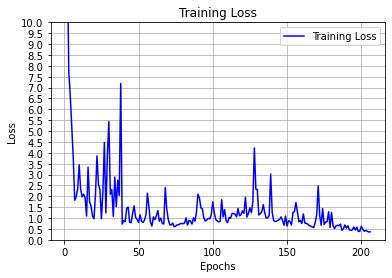

In [43]:
# Obtain the loss values from the training history
loss_values = history_right.history['loss']

# Plot the loss graph
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xlim(0, len(loss_values) + 10)
# plt.ylim(0, max(loss_values) + 0.1)
plt.ylim(0, 10)
plt.grid(True)
# plt.yticks(range(0, 11, 1))
plt.yticks([i / 2 for i in range(0, 21)])

plt.legend()
plt.show()

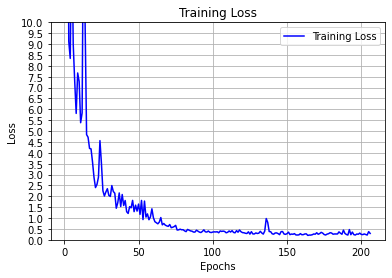

In [35]:
# Obtain the loss values from the training history
loss_values = history_left.history['loss']

# Plot the loss graph
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xlim(0, len(loss_values) + 10)
# plt.ylim(0, max(loss_values) + 0.1)
plt.ylim(0, 10)
plt.grid(True)
# plt.yticks(range(0, 11, 1))
plt.yticks([i / 2 for i in range(0, 21)])

plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [43]:
Y_pred_left = model_left.predict(X_test1_left)

mse_left = mean_squared_error(Y_test_left, Y_pred_left)

rmse_left = np.sqrt(mse_left)

mae_left = mean_absolute_error(Y_test_left, Y_pred_left)

r2_left = r2_score(Y_test_left, Y_pred_left)

print('Mean Squared Error (MSE):', mse_left)
print('Root Mean Squared Error (RMSE):', rmse_left)
print('Mean Absolute Error (MAE):', mae_left)
print('R-squared (R2):', r2_left)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-24 08:11:38.848958: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5/BiasAdd' id:480 op device:{requested: '', assigned: ''} def:{{{node dense_5/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_5/MatMul, dense_5/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Mean Squared Error (MSE): 0.42900051277147244
Root Mean Squared Error (RMSE): 0.6549813071924057
Mean Absolute Error (MAE): 0.5294905682070201
R-squared (R2): 0.9191505042395187


In [37]:
Y_pred_right = model_right.predict(X_test1_right)

mse_right = mean_squared_error(Y_test_right, Y_pred_right)

rmse_right = np.sqrt(mse_right)

mae_right = mean_absolute_error(Y_test_right, Y_pred_right)

r2_right = r2_score(Y_test_right, Y_pred_right)

print('Mean Squared Error (MSE):', mse_right)
print('Root Mean Squared Error (RMSE):', rmse_right)
print('Mean Absolute Error (MAE):', mae_right)
print('R-squared (R2):', r2_right)

Mean Squared Error (MSE): 0.08760482719966942
Root Mean Squared Error (RMSE): 0.29598112642475943
Mean Absolute Error (MAE): 0.2457831971656284
R-squared (R2): 0.9724596929089615


In [39]:
Y_pred_right = model_right.predict(X_test1_right)

mse_right = mean_squared_error(Y_test_right, Y_pred_right)

rmse_right = np.sqrt(mse_right)

mae_right = mean_absolute_error(Y_test_right, Y_pred_right)

r2_right = r2_score(Y_test_right, Y_pred_right)

print('Mean Squared Error (MSE):', mse_right)
print('Root Mean Squared Error (RMSE):', rmse_right)
print('Mean Absolute Error (MAE):', mae_right)
print('R-squared (R2):', r2_right)

Mean Squared Error (MSE): 0.08760482719966942
Root Mean Squared Error (RMSE): 0.29598112642475943
Mean Absolute Error (MAE): 0.2457831971656284
R-squared (R2): 0.9724596929089615


In [37]:

Y_pred_left = model_left.predict(X_test1_left)

mse_left = mean_squared_error(Y_test_left, Y_pred_left)

rmse_left = np.sqrt(mse_left)

mae_left = mean_absolute_error(Y_test_left, Y_pred_left)

r2_left = r2_score(Y_test_left, Y_pred_left)

print('Mean Squared Error (MSE):', mse_left)
print('Root Mean Squared Error (RMSE):', rmse_left)
print('Mean Absolute Error (MAE):', mae_left)
print('R-squared (R2):', r2_left)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-10 12:15:41.137232: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/BiasAdd' id:110 op device:{requested: '', assigned: ''} def:{{{node dense_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_1/MatMul, dense_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-10 12:15:41.652614: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds read

Mean Squared Error (MSE): 1.3393592501387221
Root Mean Squared Error (RMSE): 1.1573068953992809
Mean Absolute Error (MAE): 0.9303274166752629
R-squared (R2): 0.5248077680313088


In [45]:

Y_pred_right = model_right.predict(X_test1_right)

mse_right = mean_squared_error(Y_test_right, Y_pred_right)

rmse_right = np.sqrt(mse_right)

mae_right = mean_absolute_error(Y_test_right, Y_pred_right)

r2_right = r2_score(Y_test_right, Y_pred_right)

print('Mean Squared Error (MSE):', mse_right)
print('Root Mean Squared Error (RMSE):', rmse_right)
print('Mean Absolute Error (MAE):', mae_right)
print('R-squared (R2):', r2_right)

Mean Squared Error (MSE): 0.38224711712045034
Root Mean Squared Error (RMSE): 0.6182613663495806
Mean Absolute Error (MAE): 0.48053566722791335
R-squared (R2): 0.8569852701042917


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


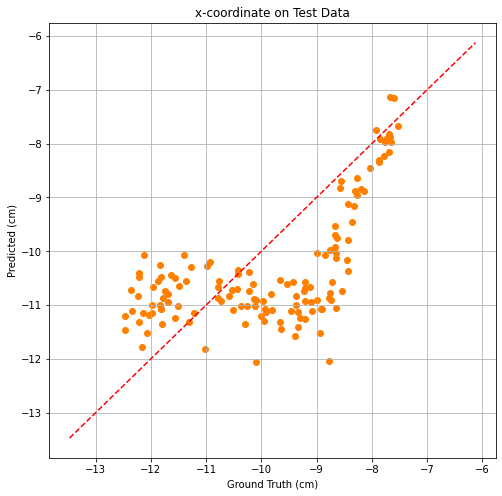

In [38]:
predicted_values = model_left.predict(X_test1_left)

#For x-coordinate
predicted_first_output = predicted_values[:, 0]
ground_truth_first_output = Y_test_left[:, 0]

darker_orange = (1.0, 0.5, 0.0) 

axis_limits = [
    (min(min(ground_truth_first_output), min(predicted_first_output)) - 1),
    (max(max(ground_truth_first_output), max(predicted_first_output)) + 1)
]


# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(ground_truth_first_output, predicted_first_output, c=darker_orange, marker='o')
plt.xlabel('Ground Truth (cm)')
plt.ylabel('Predicted (cm)')
plt.title('x-coordinate on Test Data')
plt.grid(True)

# Add a diagonal line from the origin
plt.plot(axis_limits, axis_limits, color='red', linestyle='--')

plt.show()

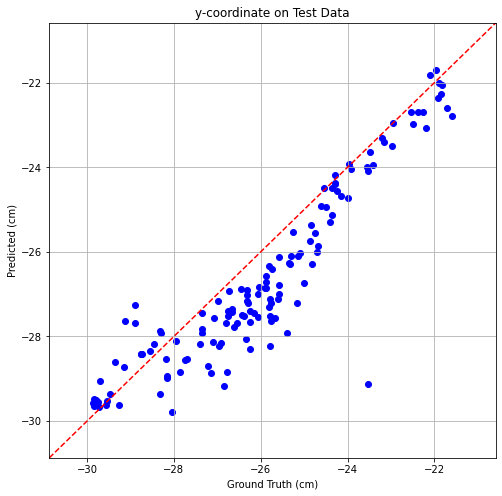

In [39]:
#For y-coordinate
predicted_second_output = predicted_values[:, 1]
ground_truth_second_output = Y_test_left[:, 1]

axis_limits = [
    (min(min(ground_truth_second_output), min(predicted_second_output)) - 1),
    (max(max(ground_truth_second_output), max(predicted_second_output)) + 1)
]

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(ground_truth_second_output, predicted_second_output, c='blue', marker='o')
plt.xlabel('Ground Truth (cm)')
plt.ylabel('Predicted (cm)')
plt.title('y-coordinate on Test Data')
plt.grid(True)
# plt.axis('equal') # Set equal aspect ratio for the axes

# Set common axis limits for both x and y axes
plt.xlim(axis_limits)
plt.ylim(axis_limits)

# Add a diagonal line from the origin
plt.plot(axis_limits, axis_limits, color='red', linestyle='--')

plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


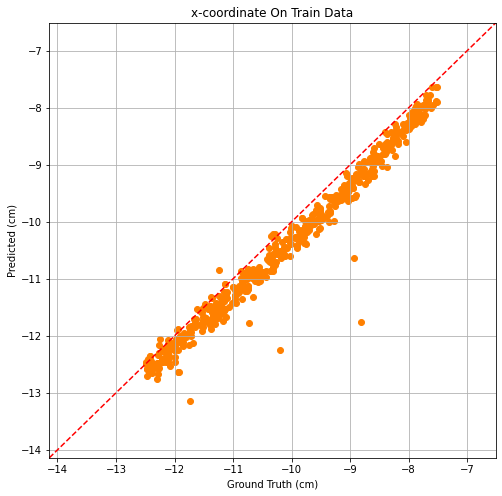

In [40]:
darker_orange = (1.0, 0.5, 0.0) 
predicted_values_ontrain = model_left.predict(X_train1_left)

#For x-coordinate
predicted_ontrain_forx = predicted_values_ontrain[:, 0]
ground_truth_ontrain_forx = Y_train_left[:, 0]


axis_limits = [
    (min(min(ground_truth_ontrain_forx), min(predicted_ontrain_forx)) - 1),
    (max(max(ground_truth_ontrain_forx), max(predicted_ontrain_forx)) + 1)
]


# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(ground_truth_ontrain_forx, predicted_ontrain_forx, c=darker_orange, marker='o')
plt.xlabel('Ground Truth (cm)')
plt.ylabel('Predicted (cm)')
plt.title('x-coordinate On Train Data')
plt.grid(True)

# Set common axis limits for both x and y axes
plt.xlim(axis_limits)
plt.ylim(axis_limits)

# Add a diagonal line from the origin
plt.plot(axis_limits, axis_limits, color='red', linestyle='--')

plt.show()

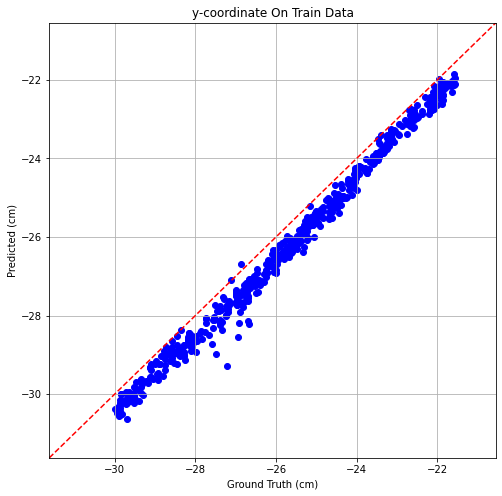

In [41]:
#For y-coordinate
predicted_ontrain_fory = predicted_values_ontrain[:, 1]
ground_truth_ontrain_fory = Y_train_left[:, 1]



axis_limits = [
    (min(min(ground_truth_ontrain_fory), min(predicted_ontrain_fory)) - 1),
    (max(max(ground_truth_ontrain_fory), max(predicted_ontrain_fory)) + 1)
]

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(ground_truth_ontrain_fory, predicted_ontrain_fory, c='blue', marker='o')
plt.xlabel('Ground Truth (cm)')
plt.ylabel('Predicted (cm)')
plt.title('y-coordinate On Train Data')
plt.grid(True)

# Set common axis limits for both x and y axes
plt.xlim(axis_limits)
plt.ylim(axis_limits)

# Add a diagonal line from the origin
plt.plot(axis_limits, axis_limits, color='red', linestyle='--')

plt.show()

In [ ]:
x_range = np.max(np.abs(ground_truth_first_output))
y_range = np.max(np.abs(predicted_first_output))


"""
min x_actual: -24.902411819307858
max x_actual: 11.010352233852014
min y_actual: -37.718261747364686
max y_actual: -27.563701906036318
"""

plt.xlim(-x_range, x_range)
plt.ylim(-y_range, y_range)

--------------------------###################-------------------------##############################---------------------------########################

                        For right direction

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


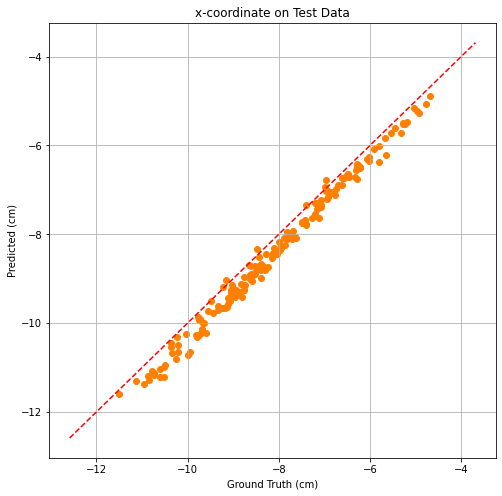

In [40]:
predicted_values = model_right.predict(X_test1_right)

#For x-coordinate
predicted_first_output = predicted_values[:, 0]
ground_truth_first_output = Y_test_right[:, 0]

darker_orange = (1.0, 0.5, 0.0) 

axis_limits = [
    (min(min(ground_truth_first_output), min(predicted_first_output)) - 1),
    (max(max(ground_truth_first_output), max(predicted_first_output)) + 1)
]


# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(ground_truth_first_output, predicted_first_output, c=darker_orange, marker='o')
plt.xlabel('Ground Truth (cm)')
plt.ylabel('Predicted (cm)')
plt.title('x-coordinate on Test Data')
plt.grid(True)

# Add a diagonal line from the origin
plt.plot(axis_limits, axis_limits, color='red', linestyle='--')

plt.show()

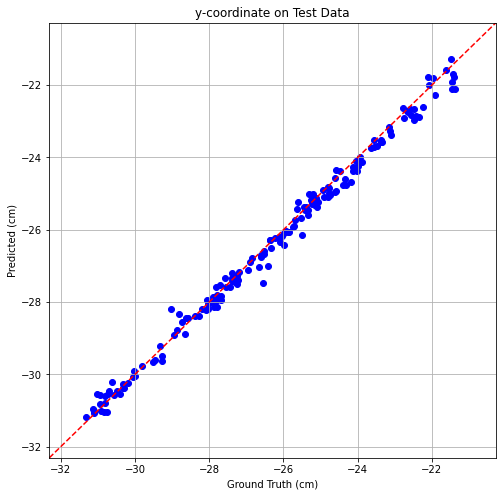

In [41]:
#For y-coordinate
predicted_second_output = predicted_values[:, 1]
ground_truth_second_output = Y_test_right[:, 1]

axis_limits = [
    (min(min(ground_truth_second_output), min(predicted_second_output)) - 1),
    (max(max(ground_truth_second_output), max(predicted_second_output)) + 1)
]

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(ground_truth_second_output, predicted_second_output, c='blue', marker='o')
plt.xlabel('Ground Truth (cm)')
plt.ylabel('Predicted (cm)')
plt.title('y-coordinate on Test Data')
plt.grid(True)
# plt.axis('equal') # Set equal aspect ratio for the axes

# Set common axis limits for both x and y axes
plt.xlim(axis_limits)
plt.ylim(axis_limits)

# Add a diagonal line from the origin
plt.plot(axis_limits, axis_limits, color='red', linestyle='--')

plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


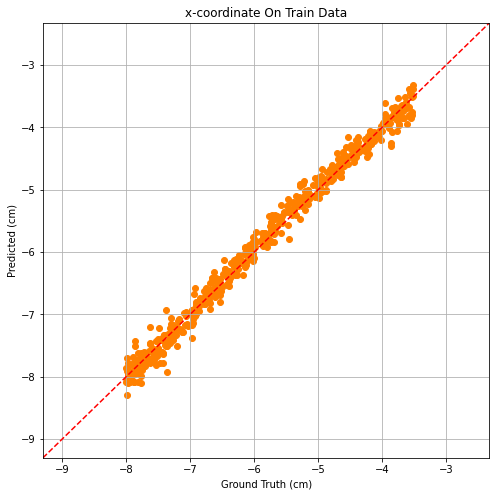

In [47]:
darker_orange = (1.0, 0.5, 0.0) 
predicted_values_ontrain = model_right.predict(X_train1_right)

#For x-coordinate
predicted_ontrain_forx = predicted_values_ontrain[:, 0]
ground_truth_ontrain_forx = Y_train_right[:, 0]


axis_limits = [
    (min(min(ground_truth_ontrain_forx), min(predicted_ontrain_forx)) - 1),
    (max(max(ground_truth_ontrain_forx), max(predicted_ontrain_forx)) + 1)
]


# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(ground_truth_ontrain_forx, predicted_ontrain_forx, c=darker_orange, marker='o')
plt.xlabel('Ground Truth (cm)')
plt.ylabel('Predicted (cm)')
plt.title('x-coordinate On Train Data')
plt.grid(True)

# Set common axis limits for both x and y axes
plt.xlim(axis_limits)
plt.ylim(axis_limits)

# Add a diagonal line from the origin
plt.plot(axis_limits, axis_limits, color='red', linestyle='--')

plt.show()

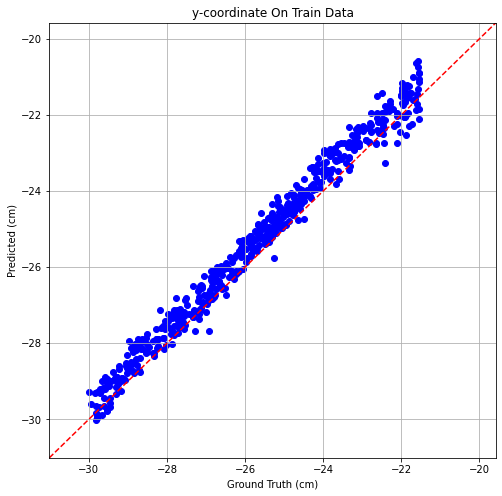

In [48]:
#For y-coordinate
predicted_ontrain_fory = predicted_values_ontrain[:, 1]
ground_truth_ontrain_fory = Y_train_right[:, 1]



axis_limits = [
    (min(min(ground_truth_ontrain_fory), min(predicted_ontrain_fory)) - 1),
    (max(max(ground_truth_ontrain_fory), max(predicted_ontrain_fory)) + 1)
]

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(ground_truth_ontrain_fory, predicted_ontrain_fory, c='blue', marker='o')
plt.xlabel('Ground Truth (cm)')
plt.ylabel('Predicted (cm)')
plt.title('y-coordinate On Train Data')
plt.grid(True)

# Set common axis limits for both x and y axes
plt.xlim(axis_limits)
plt.ylim(axis_limits)

# Add a diagonal line from the origin
plt.plot(axis_limits, axis_limits, color='red', linestyle='--')

plt.show()

## Testing

In [39]:
sample_index = 6  # Replace with the index of the desired sample

sample = np.expand_dims(X_test1_left[sample_index], axis=0) 

y_pred = model_left.predict(sample)

print('Prediction:', y_pred)

Prediction: [[-11.7657585 -30.747107 ]]


In [40]:
print(Y_test_left[6])

[-11.72666146 -33.2833967 ]


In [5]:
sess.close()
tf.reset_default_graph()


In [1]:
!nvidia-smi # A command to view the NVIDIA GPU details (especially to view the memory usage while running the code) 

Fri Jul 28 10:38:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX 6000...  On   | 00000000:41:00.0 Off |                  Off |
| 55%   77C    P2   270W / 300W |  40369MiB / 49140MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX 6000...  On   | 00000000:61:00.0 Off |                  Off |
| 30%   